# 01. PyTorch Workflow Fundamentals

![image](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png)

In [1]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.4.0+cu121'

Machine learning is a game of two parts:

    Turn your data, whatever it is, into numbers (a representation).
    Pick or build a model to learn the representation as best as possible.

We'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [3]:
# Create *known* parameters -> y = mx + b
weight = 0.7 # m
bias = 0.3 # b

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step)
print(X)
X = X.unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
        0.1800, 0.2000, 0.2200, 0.2400, 0.2600, 0.2800, 0.3000, 0.3200, 0.3400,
        0.3600, 0.3800, 0.4000, 0.4200, 0.4400, 0.4600, 0.4800, 0.5000, 0.5200,
        0.5400, 0.5600, 0.5800, 0.6000, 0.6200, 0.6400, 0.6600, 0.6800, 0.7000,
        0.7200, 0.7400, 0.7600, 0.7800, 0.8000, 0.8200, 0.8400, 0.8600, 0.8800,
        0.9000, 0.9200, 0.9400, 0.9600, 0.9800])


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

We split our data as follows:

| Split | Purpose | Amount of total data | How often is it used? 
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |

In [4]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(7, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

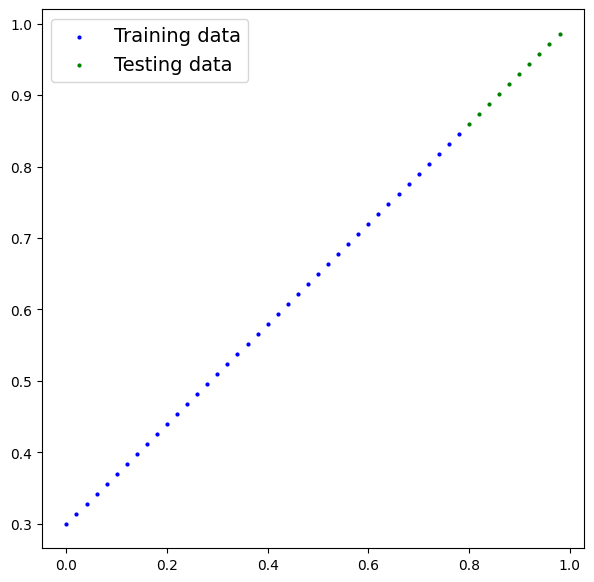

In [6]:
plot_predictions()

In [7]:
# Linear Regression model class in torchy
class LinearRegressionModel(nn.Module): # <- almost everything in torch is a nn.Module (is da base class)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True) # start with random weights, float32, and requires_grad
        self.bias    = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        return self.weights * x + self.bias # linear regression formula, equal to "mx + b"


## PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are `torch.nn`, `torch.optim`, `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`.

- `torch.nn` contains all of the building blocks for computational graphs
- `torch.nn.Parameter` stores tensors that can be used with `nn.Module`. `requires_grad` allows for gradients to be automatically calculated (aka "autograd")
- `torch.nn.Module` base class for all nn modules, all building blocks for nn are subclassed from this. It requires a `forward()` method to be implemented
- `torch.optim` contains various optimizatino algos (tells the model params in `nn.Parameter` how to best change to improve gradient descent and in turn reduce loss)
- 

In [8]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making predictions using torch.inference_mode()

Let's check how well the untrained model predicts y when x is passed into it

In [10]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

As the name suggests, torch.inference_mode() is used when using a model for inference (making predictions).

torch.inference_mode() turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make **forward-passes** (data going through the forward() method) faster.

In [11]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


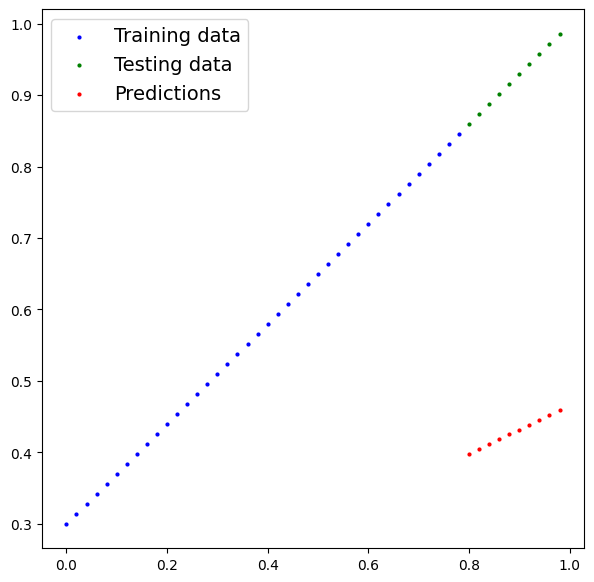

In [12]:
plot_predictions(predictions=y_preds)

In [13]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

## Train model (create a loss function and optimized in PyTorch)

For our model to update its parameters on its own, we'll need to add a loss function as well as an optimizer.

| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your models predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). 

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer.

In [14]:
# Since we are doing linear regression here, we ll use MAE (mean abs error)
# For optimization, we ll use SDD torch.optim.SGD(params, lr)  -> params are the model weights and biases, and lr is the learning rate (learning rate is considered to be a hyper parameter)

# Create the loss function
loss_fn = nn.L1Loss() # L1Loss == MAE loss

# Create the optimized
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

## Creating an optimization loop in PyTorch

Time to create the **training** loop and **testing** loop

**The loop looks as follows:**

1. Forward pass
2. Calculate loss (compare predictions to ground truth)
3. Zero grad
4. Backprop
5. Update optimizer (gradient descent)

In [15]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 200

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    # Put model in training mode (this is the default state of a model)
    model_0.train()
    
    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)
    
    # 3. Zero grad of the optimizer
    optimizer.zero_grad()
    
    # 4. Loss backwards
    loss.backward()
    
    # 5. Progress the optimizer
    optimizer.step()
    
    ### Testing
    
    # Put the model in evaluation mode
    model_0.eval()
    
    with torch.inference_mode():
        # 1. Forward pass on test data
        test_pred = model_0(X_test)

        # 2. Caculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

        # Print out what's happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 
Epoch: 100 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262 
Epoch: 110 | MAE Train Loss: 0.021020207554101944 | MAE

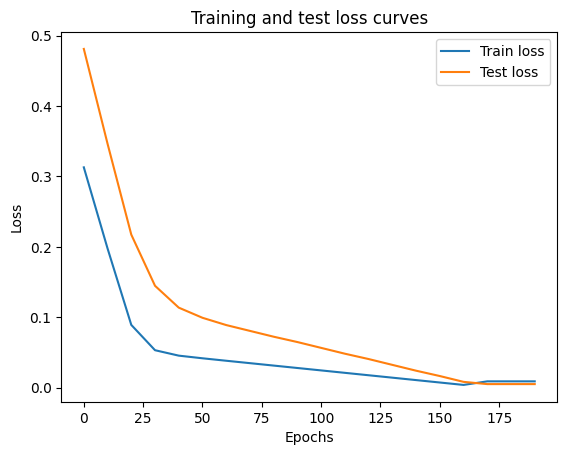

In [16]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [17]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## Making predictions with a trained PyTorch model (inference)

3 things to remember when making predictions:
1. Set  the model in evaluation mode (`model.eval()`)
2. Make the predictions using the inference mode context manager (`with torch.inference_mode(): ...`)
3. All predictions should be made with objects on the same device (e.g. data and models on GPU only or data and model on CPU only)

The first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

In [18]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
    # 3. Make sure the calculations are done with the model and data on the same device
    # in our case, we haven't setup device-agnostic code yet so our data and model are
    # on the CPU by default.
    # model_0.to(device)
    # X_test = X_test.to(device)
    y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

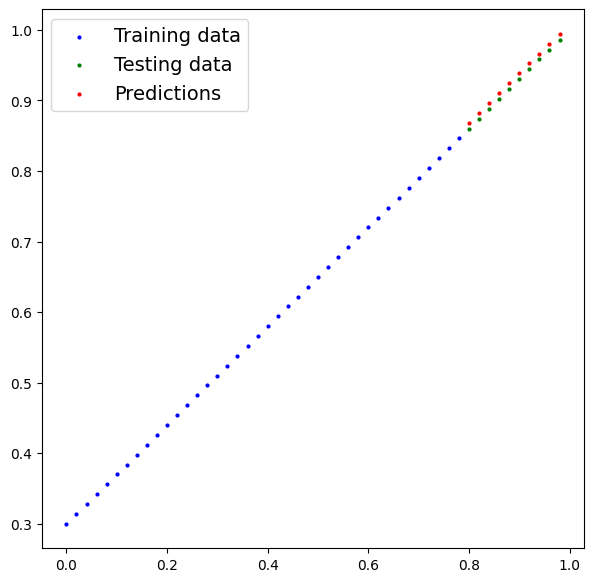

In [19]:
plot_predictions(predictions=y_preds)

## Saving and loading a PyTorch model

For saving and loading models in PyTorch, there are three main methods you should be aware of:

|PyTorch method | What does it do? |
|---------------|------------------|
| `torch.save` | Saves a serialized object to disk using Python's `pickle` utility. Models, tensors and various other Python objects like dicts can eb saved using `torch.save`|
| `torch.load` | Uses `pickle`'s unpickling feature to deserialize and load pickled Python object files (like models tensors, or dicts) into memory. You can also set which device to load the object to (GCPU, GPU etc..) |
| `torch.nn.Module.load_state_dict` | Loads a models parameter dict (`model.state_dict()`) using a saved `stated_dict()` object.

> `pickle` is not secure, so don't load modules you dont trust w it

### Saving a PyTorch model's `state_dict()`

The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`. We can do this in the following steps:

1. We ll create a directory for saving models to called `models` using Python's `pathlib` module
2. We ll create a file path to save the model to
3. We ll call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` si the filename of where to save the model

It's convention to save models to end with `.pt` or `pth`, like `saved_model_01.pth`

In [20]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_0.pth


### Loading a saved PyTorch model's

Since the `state_dict` is now saved at `/models/...`, we can load it using `torch.nn.Module.load_state_dict(torch.load(f))`, where `f` is the filepath of our saved model `state_dict()`.

Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`?

Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the entire model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of nn.Module).

Why not save the entire model?

Saving the entire model rather than just the state_dict() is more intuitive, however, to quote the PyTorch documentation:

    The disadvantage of this approach (saving the whole model) is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...

    Because of this, your code can break in various ways when used in other projects or after refactors.


Let's test it out by created another instance of LinearRegressionModel(), which is a subclass of torch.nn.Module and will hence have the in-built method load_state_dict().

In [22]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

/tmp/ipykernel_5074/1296048670.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

Excellent! It looks like things matched up.

Now to test our loaded model, let's perform inference with it (make predictions) on the test data.

In [23]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [24]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

**In 01_putting_it_all_together, I ll put a short version of all of the above w less commentary**